In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Analysis:

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("googleai/pfam-seed-random-split")

print("Path to dataset files:", path)

100%|██████████| 493M/493M [00:06<00:00, 84.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/googleai/pfam-seed-random-split/versions/1


In [ ]:
# Function to read and combine all files
def load_and_combine(folder_path):
    all_files = [f for f in os.listdir(folder_path)]
    df_list = [pd.read_csv(os.path.join(folder_path, file)) for file in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

train_path = os.path.join(path, "random_split/train")
dev_path = os.path.join(path, "random_split/dev")
test_path = os.path.join(path, "random_split/test")

# Load and combine data
train_df = load_and_combine(train_path)
dev_df = load_and_combine(dev_path)
test_df = load_and_combine(test_path)

# Basic details on datasets
print("Train DataFrame Shape:", train_df.shape)
print("Train DataFrame Info:", train_df.info())

print("Dev DataFrame Shape:", dev_df.shape)
print("Dev DataFrame Info:", dev_df.info())

print("Test DataFrame Shape:", test_df.shape)
print("Test DataFrame Info:", test_df.info())

Train DataFrame Shape: (1086741, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086741 entries, 0 to 1086740
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   family_id         1086741 non-null  object
 1   sequence_name     1086741 non-null  object
 2   family_accession  1086741 non-null  object
 3   aligned_sequence  1086741 non-null  object
 4   sequence          1086741 non-null  object
dtypes: object(5)
memory usage: 41.5+ MB
Train DataFrame Info: None
Dev DataFrame Shape: (126171, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126171 entries, 0 to 126170
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   family_id         126171 non-null  object
 1   sequence_name     126171 non-null  object
 2   family_accession  126171 non-null  object
 3   aligned_sequence  126171 non-null  object
 4   sequence          

In [ ]:
train_df['family_accession'].value_counts()

,count
family_accession,
PF13649.6,3637
PF00560.33,1927
PF13508.7,1761
PF06580.13,1537
PF02397.16,1528
...,...
PF13321.6,1
PF17566.2,1
PF05414.11,1


In [ ]:
dev_df['family_accession'].value_counts()

,count
family_accession,
PF13649.6,454
PF00560.33,240
PF13508.7,219
PF06580.13,192
PF02397.16,190
...,...
PF06355.13,1
PF13257.6,1
PF17009.5,1


In [ ]:
test_df['family_accession'].value_counts()

,count
family_accession,
PF13649.6,454
PF00560.33,240
PF13508.7,219
PF06580.13,192
PF02397.16,190
...,...
PF18868.1,1
PF10008.9,1
PF09943.9,1


In [ ]:
train_family_accession = set(train_df['family_accession'].unique())
dev_family_accession = set(dev_df['family_accession'].unique())
test_family_accession = set(test_df['family_accession'].unique())

common_families = train_family_accession & dev_family_accession & test_family_accession # Take the intersection with the '&' operator
print('Number of common Pfam families in all three sets: ', len(common_families))

Number of common Pfam families in all three sets:  13071


In [ ]:
# Exclude the exclusive families as these cannot be validated with the other sets
train_df = train_df[train_df['family_accession'].isin(common_families)]

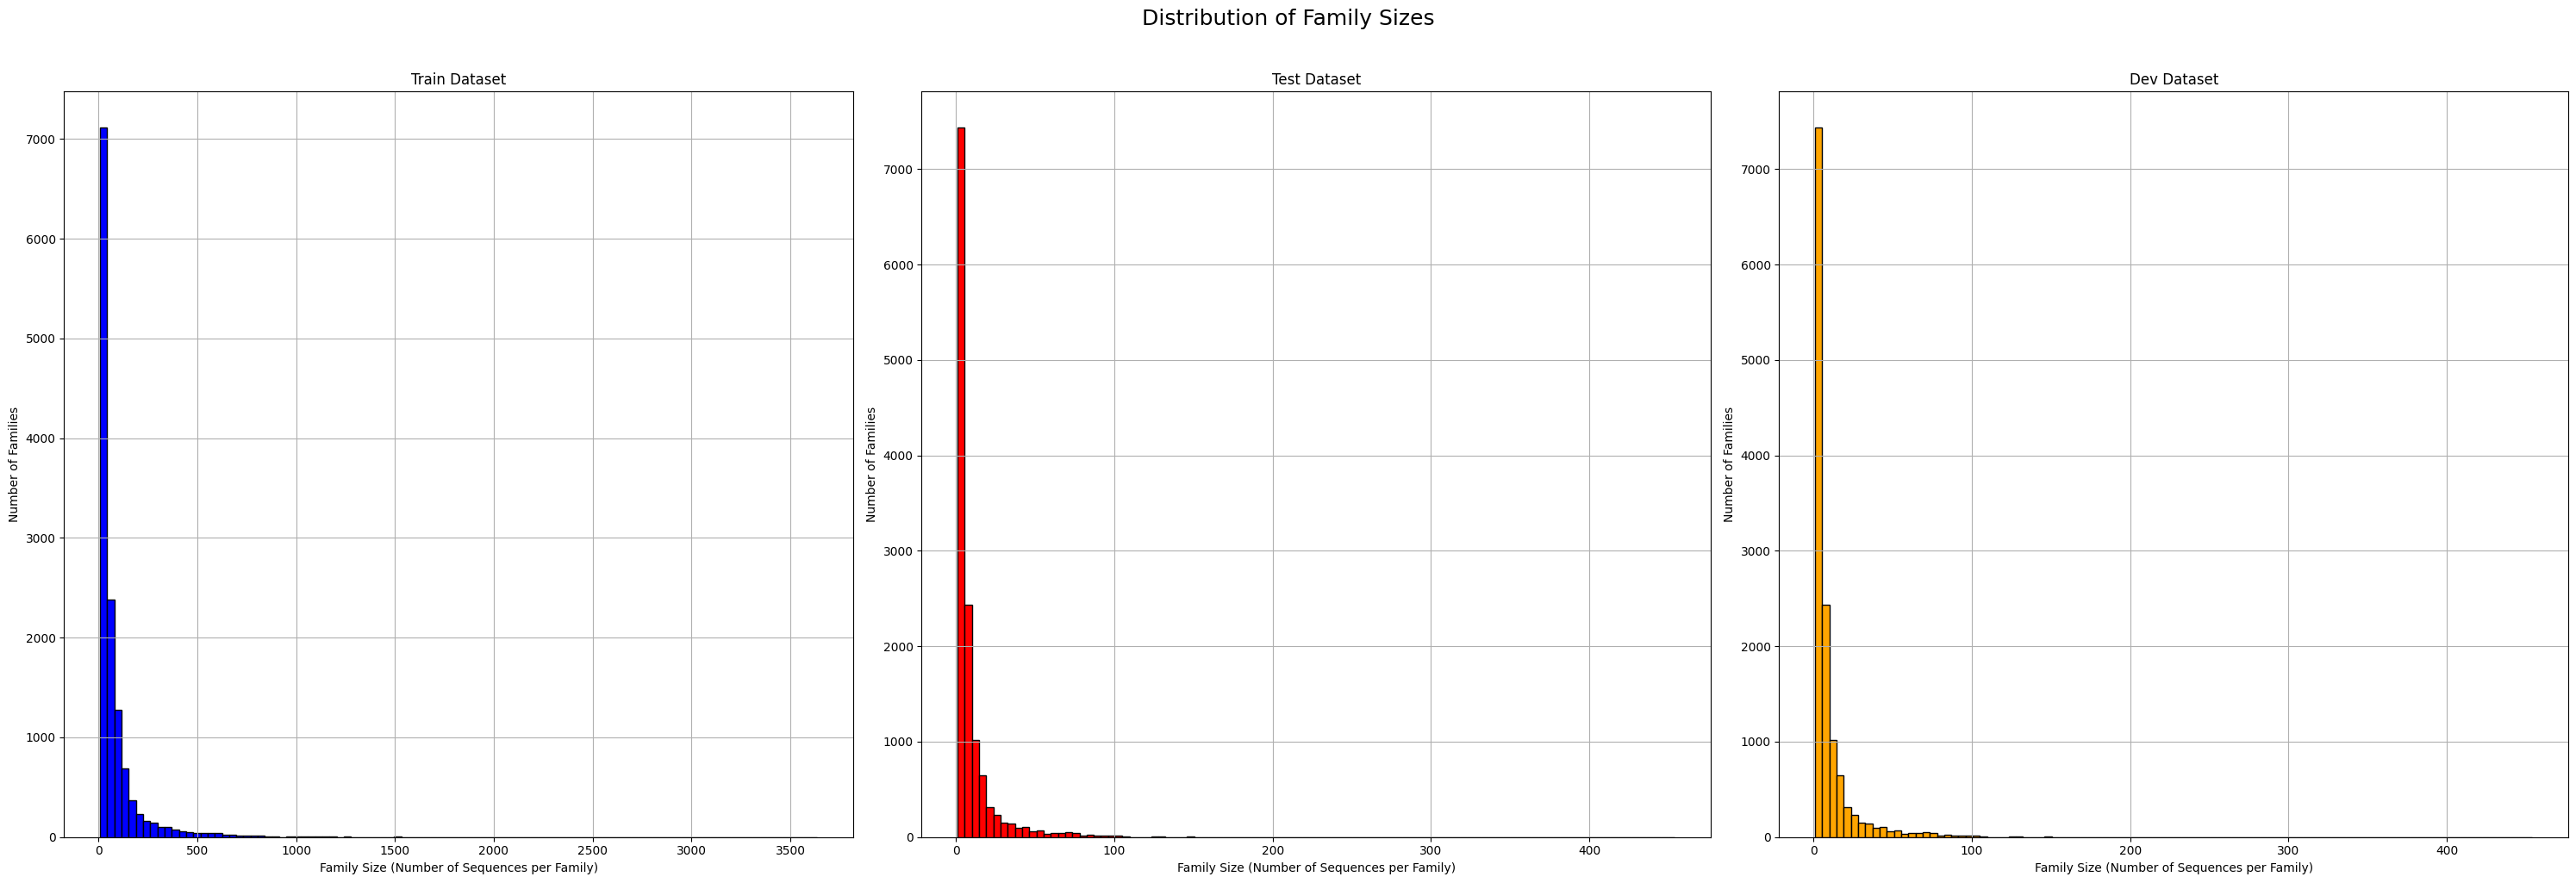

In [ ]:
# Number of samples per family_accession distribution

# Set figure size
plt.figure(figsize=(30, 10))

# Title
plt.suptitle("Distribution of Family Sizes", fontsize=18, y=1.02)

# Create the subplot
ax = plt.subplot(1, 3, 1)
ax.set_title("Train Dataset")
ax.set_xlabel("Family Size (Number of Sequences per Family)")
ax.set_ylabel("Number of Families")

# Compute family sizes
family_sizes_train = train_df.groupby("family_accession").size()

# Plot histogram
family_sizes_train.hist(bins=100, ax=ax, color="blue", edgecolor="black")

# Create the subplot
ax = plt.subplot(1, 3, 2)
ax.set_title("Test Dataset")
ax.set_xlabel("Family Size (Number of Sequences per Family)")
ax.set_ylabel("Number of Families")

# Compute family sizes
family_sizes_test = test_df.groupby("family_accession").size()

# Plot histogram
family_sizes_test.hist(bins=100, ax=ax, color="red", edgecolor="black")

# Create the subplot
ax = plt.subplot(1, 3, 3)
ax.set_title("Dev Dataset")
ax.set_xlabel("Family Size (Number of Sequences per Family)")
ax.set_ylabel("Number of Families")

# Compute family sizes
family_sizes_dev = dev_df.groupby("family_accession").size()

# Plot histogram
family_sizes_dev.hist(bins=100, ax=ax, color="orange", edgecolor="black")

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Take the 100 most frequent families

most_freq_family_accession = set(train_df['family_accession'].value_counts()[:100].index)

train_df = train_df[train_df['family_accession'].isin(most_freq_family_accession)]
test_df = test_df[test_df['family_accession'].isin(most_freq_family_accession)]
dev_df = dev_df[dev_df['family_accession'].isin(most_freq_family_accession)]

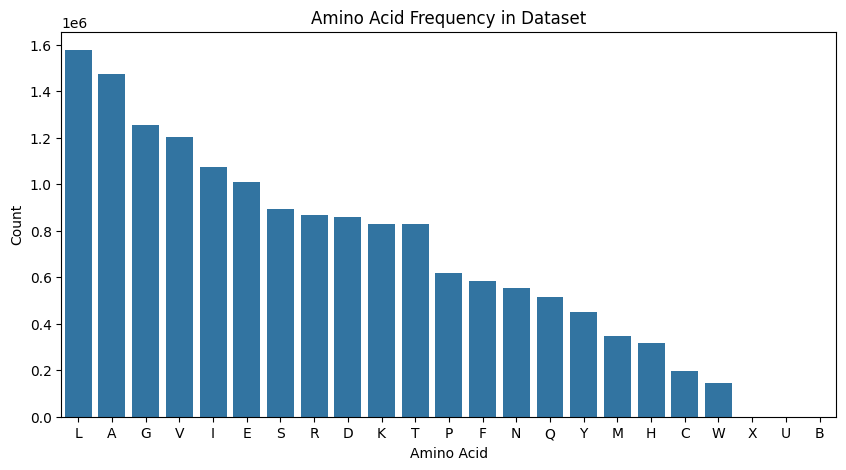

In [ ]:
aa_counts = Counter("".join(pd.concat([train_df["sequence"], test_df["sequence"], dev_df["sequence"] ])))

# Convert to DataFrame for plotting
aa_df = pd.DataFrame(aa_counts.items(), columns=["Amino Acid", "Count"]).sort_values(by="Count", ascending=False)

# Plot amino acid frequency
plt.figure(figsize=(10, 5))
sns.barplot(x="Amino Acid", y="Count", data=aa_df)
plt.xlabel("Amino Acid")
plt.ylabel("Count")
plt.title("Amino Acid Frequency in Dataset")
plt.show()

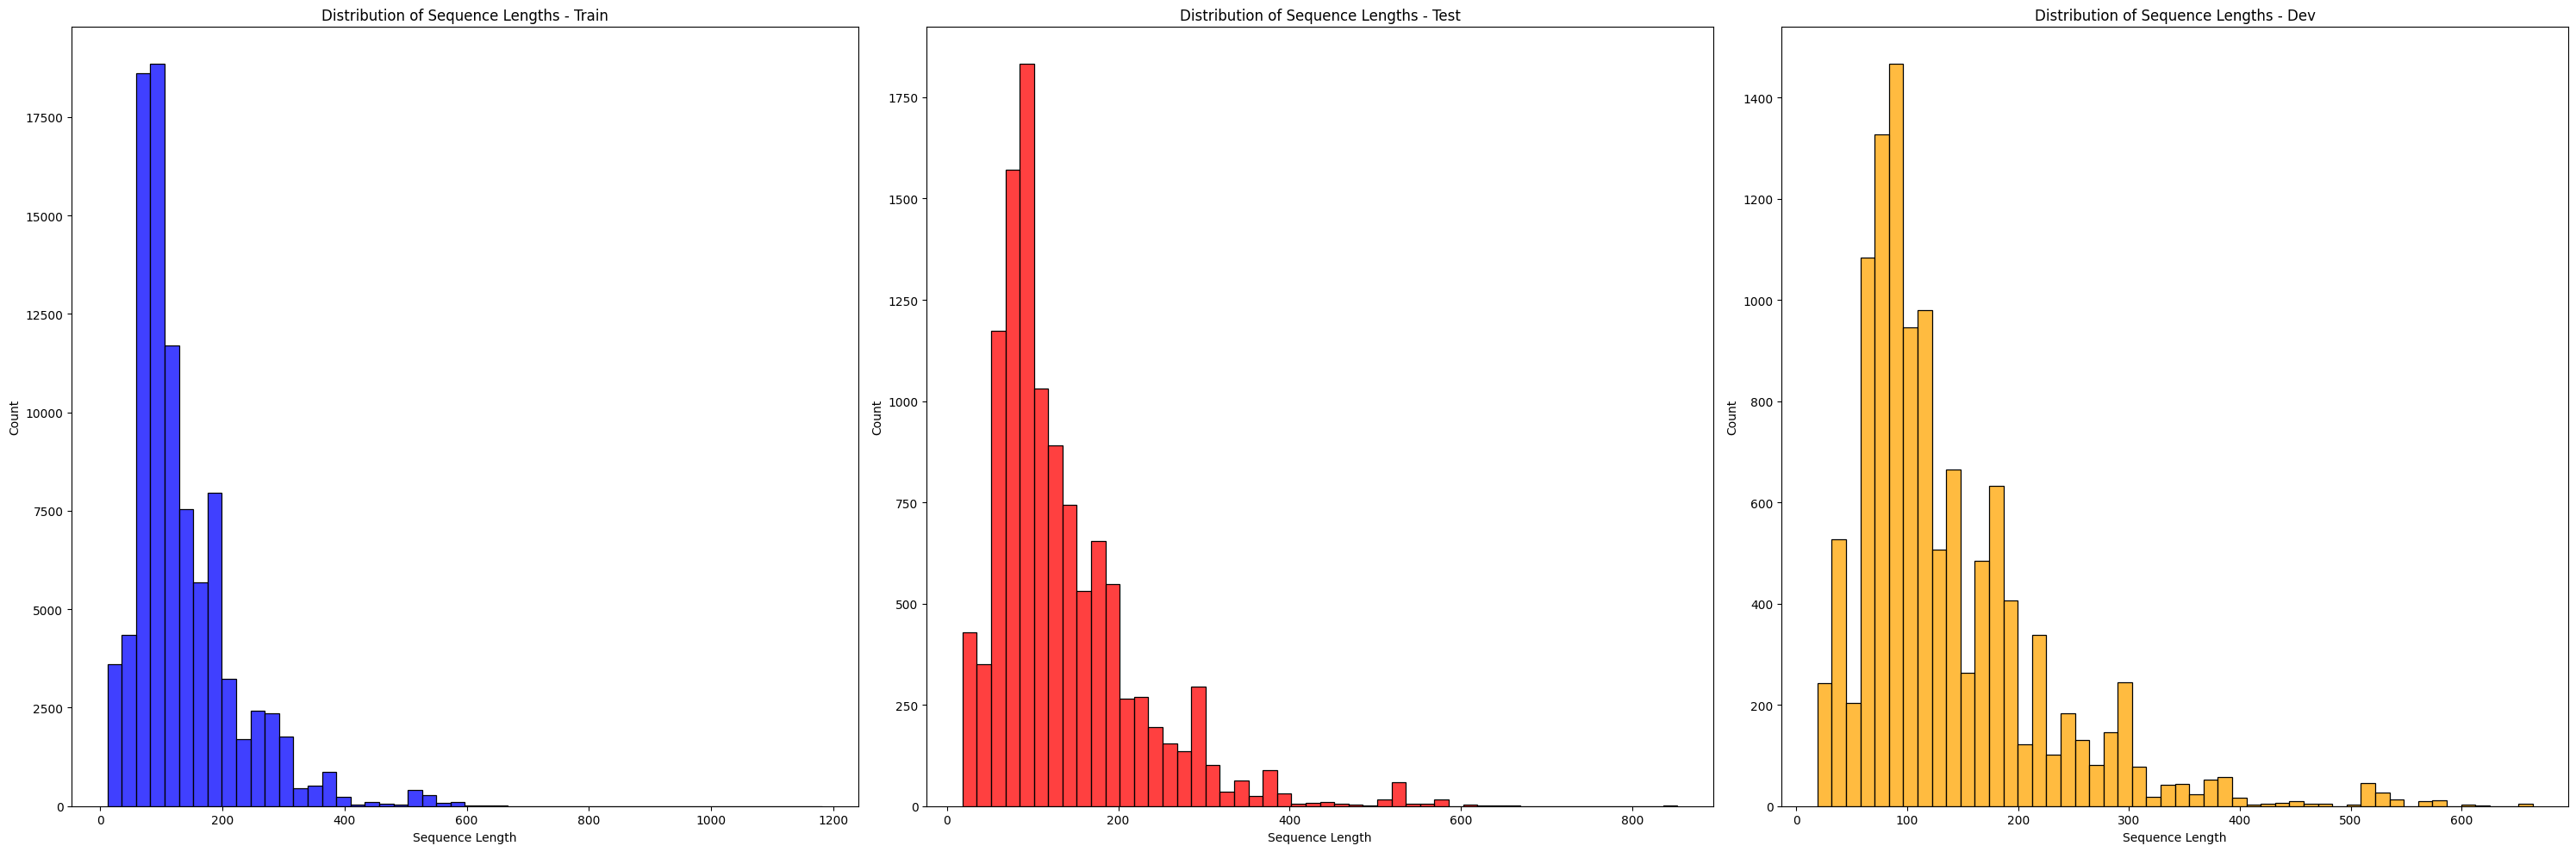

In [ ]:
# Compute sequence lengths
train_df["sequence_length"] = train_df["sequence"].apply(len)
test_df["sequence_length"] = test_df["sequence"].apply(len)
dev_df["sequence_length"] = dev_df["sequence"].apply(len)

# Histogram of sequence lengths
plt.figure(figsize=(30, 10))

ax = plt.subplot(1, 3, 1)
sns.histplot(train_df["sequence_length"], bins=50, color = 'blue')
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths - Train")

ax = plt.subplot(1, 3, 2)
sns.histplot(test_df["sequence_length"], bins=50, color = 'red')
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths - Test")

ax = plt.subplot(1, 3, 3)
sns.histplot(dev_df["sequence_length"], bins=50, color = 'orange')
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths - Dev")

plt.tight_layout()
plt.show()

#Data preprocessing:

In [ ]:
# Replace rare amino acids with a placeholder
train_df["sequence"] = train_df["sequence"].str.replace("[XUB]", "X", regex=True)
test_df["sequence"] = test_df["sequence"].str.replace("[XUB]", "X", regex=True)
dev_df["sequence"] = dev_df["sequence"].str.replace("[XUB]", "X", regex=True)

#Model Building/ Experiments:

In [ ]:
AA_ALPHABET = "LAGVIESRDTKPFNQYMHCWX"  # 20 standard amino acids + X (unknown)
MAX_LENGTH = 128 # Due to computational restricitions

# Function to one-hot encode a sequence
def one_hot_encode(seq,):
    lb = LabelBinarizer()
    lb.fit(list(AA_ALPHABET))

    # Encode sequence and pad/truncate to fixed length
    seq = list(seq[:MAX_LENGTH]) + ["X"] * (MAX_LENGTH - len(seq))
    return lb.transform(seq).T  # Transpose to get shape (21, MAX_LENGTH)

# Apply one-hot encoding
X_train = np.stack(train_df["sequence"].apply(one_hot_encode))
X_dev = np.stack(dev_df["sequence"].apply(one_hot_encode))
X_test = np.stack(test_df["sequence"].apply(one_hot_encode))

# Reshape for CNN
X_train_CNN = X_train.reshape(X_train.shape[0], 21, MAX_LENGTH, 1)
X_dev_CNN = X_dev.reshape(X_dev.shape[0], 21, MAX_LENGTH, 1)
X_test_CNN = X_test.reshape(X_test.shape[0], 21, MAX_LENGTH, 1)

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["family_accession"])
y_dev = le.transform(dev_df["family_accession"])
y_test = le.transform(test_df["family_accession"])

Baseline CNN

In [ ]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(21, MAX_LENGTH, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(len(le.classes_), activation="softmax")
])

# Compile
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 19, 126, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 63, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18144)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,322,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,335,780 (8.91 MB)

 Trainable params: 2,335,780 (8.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with validation on dev set
model.fit(X_train_CNN, y_train, epochs=10, batch_size=32, validation_data=(X_dev_CNN, y_dev)
        ,callbacks=[EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )])

Epoch 1/10
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 269s 92ms/step - accuracy: 0.8866 - loss: 0.5312 - val_accuracy: 0.9872 - val_loss: 0.0500
Epoch 2/10
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 273s 75ms/step - accuracy: 0.9954 - loss: 0.0155 - val_accuracy: 0.9809 - val_loss: 0.0671
Epoch 3/10
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 251s 72ms/step - accuracy: 0.9962 - loss: 0.0120 - val_accuracy: 0.9911 - val_loss: 0.0355
Epoch 4/10
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 268s 74ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.9919 - val_loss: 0.0352
Epoch 5/10
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 266s 75ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9869 - val_loss: 0.0644
Epoch 6/10
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 228s 79ms/step - accuracy: 0.9987 - loss: 0.0045 - val_accuracy: 0.9915 - val_loss: 0.0426
Epoch 7/10
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 212s 73ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9901 - val_loss: 0.0481
Epoch 8/10
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 272s 93ms/step - accuracy: 

In [ ]:
model.save('/content/drive/MyDrive/Pfam_Embeddings/model_1.keras')
#model = tf.keras.models.load_model('/content/drive/MyDrive/model_1.keras')

In [ ]:
# Evaluate on test set
test_acc = model.evaluate(X_test_CNN, y_test, verbose=1)[1]
print(f"CNN Test Accuracy: {test_acc:.4f}")

362/362 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9920 - loss: 0.0412
CNN Test Accuracy: 0.9932


Transformer approach

In [ ]:
# Load ESM2 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")  # 8M parameters
model2 = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

# Function to generate embeddings
def get_esm_embedding(seq):
    inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True, max_length = 128)
    with torch.no_grad():
        outputs = model2(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Mean pooling

# Compute embeddings for all sets
X_train = np.vstack(train_df["sequence"].apply(get_esm_embedding))
X_dev = np.vstack(dev_df["sequence"].apply(get_esm_embedding))
X_test = np.vstack(test_df["sequence"].apply(get_esm_embedding))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(X_train.shape)

(92983, 320)


In [ ]:
# Reshape for Transformer-based FFN
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_dev = X_dev.reshape(X_dev.shape[0], 1, X_dev.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
save_path = "/content/drive/MyDrive/Pfam_Embeddings"
#np.save(f"{save_path}/X_train_embed.npy", X_train)
#np.save(f"{save_path}/X_dev_embed.npy", X_dev)
#np.save(f"{save_path}/X_test_embed.npy", X_test)

X_train_embed = np.load(f"{save_path}/X_train_embed.npy")
X_dev_embed = np.load(f"{save_path}/X_dev_embed.npy")
X_test_embed = np.load(f"{save_path}/X_test_embed.npy")

In [ ]:
# Transformer Block
def transformer_block(x, num_heads, ff_dim, dropout_rate=0.1):
    """ Implements a single Transformer block """
    # Multi-Head Self-Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = Add()([x, attn_output])  # Residual Connection
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output)

    # Feedforward Network
    ffn = Dense(ff_dim * 2, activation="relu")(attn_output)
    ffn = Dense(ff_dim)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    ffn = Add()([attn_output, ffn])  # Residual Connection
    ffn = LayerNormalization(epsilon=1e-6)(ffn)

    return ffn

# Model Definition
def build_transformer_model(input_shape, num_classes, num_heads=2, ff_dim=320, num_transformer_blocks=2):
    """ Builds a Transformer-based classifier """
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, num_heads, ff_dim)

    # Global Max Pooling (reduce sequence to single vector)
    x = GlobalMaxPooling1D()(x)

    # Dense layers for classification
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

input_shape = (1, 320)
num_classes = 100  # 100 protein families

model_ffnn = build_transformer_model(input_shape, num_classes)
model_ffnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_ffnn.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1, 320)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 1, 320)         │        821,440 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1, 320)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 320)         │              0 │ input_layer_2[0][0],   │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 1, 320)         │            640 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1, 640)         │        205,440 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1, 320)         │        205,120 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1, 320)         │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 1, 320)         │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 1, 320)         │            640 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 1, 320)         │        821,440 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1, 320)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 1, 320)         │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 1, 320)         │            640 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 640)         │        205,440 │ layer_normalization_2… │
├──────────────────────

 Total params: 2,492,484 (9.51 MB)

 Trainable params: 2,492,484 (9.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_ffnn.fit(
    X_train_embed, y_train,
    validation_data=(X_dev_embed, y_dev),
    epochs=15,
    batch_size=32,
    verbose=1
    ,callbacks=[EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )])

Epoch 1/15
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 730s 248ms/step - accuracy: 0.1968 - loss: 3.3502 - val_accuracy: 0.6051 - val_loss: 1.2773
Epoch 2/15
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 742s 248ms/step - accuracy: 0.5454 - loss: 1.5154 - val_accuracy: 0.7512 - val_loss: 0.8582
Epoch 3/15
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 787s 263ms/step - accuracy: 0.6415 - loss: 1.2006 - val_accuracy: 0.7995 - val_loss: 0.7160
Epoch 4/15
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 712s 232ms/step - accuracy: 0.6918 - loss: 1.0412 - val_accuracy: 0.8305 - val_loss: 0.6169
Epoch 5/15
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 639s 220ms/step - accuracy: 0.7309 - loss: 0.9154 - val_accuracy: 0.8400 - val_loss: 0.5879
Epoch 6/15
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 681s 220ms/step - accuracy: 0.7578 - loss: 0.8436 - val_accuracy: 0.8625 - val_loss: 0.5349
Epoch 7/15
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 691s 223ms/step - accuracy: 0.7755 - loss: 0.7988 - val_accuracy: 0.8674 - val_loss: 0.5051
Epoch 8/15
2906/2906 ━━━━━━━━━━━━━━━━━━━━ 668s 218ms/step - ac

In [ ]:
test_loss, test_acc = model_ffnn.evaluate(X_test_embed, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

362/362 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9285 - loss: 0.3228
Test Accuracy: 0.9240


In [ ]:
model_ffnn.save('/content/drive/MyDrive/Pfam_Embeddings/model_ffnn_2.keras')
#model_ffnn = tf.keras.models.load_model('/content/drive/MyDrive/model_ffnn_1')

#Result Analysis:

362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


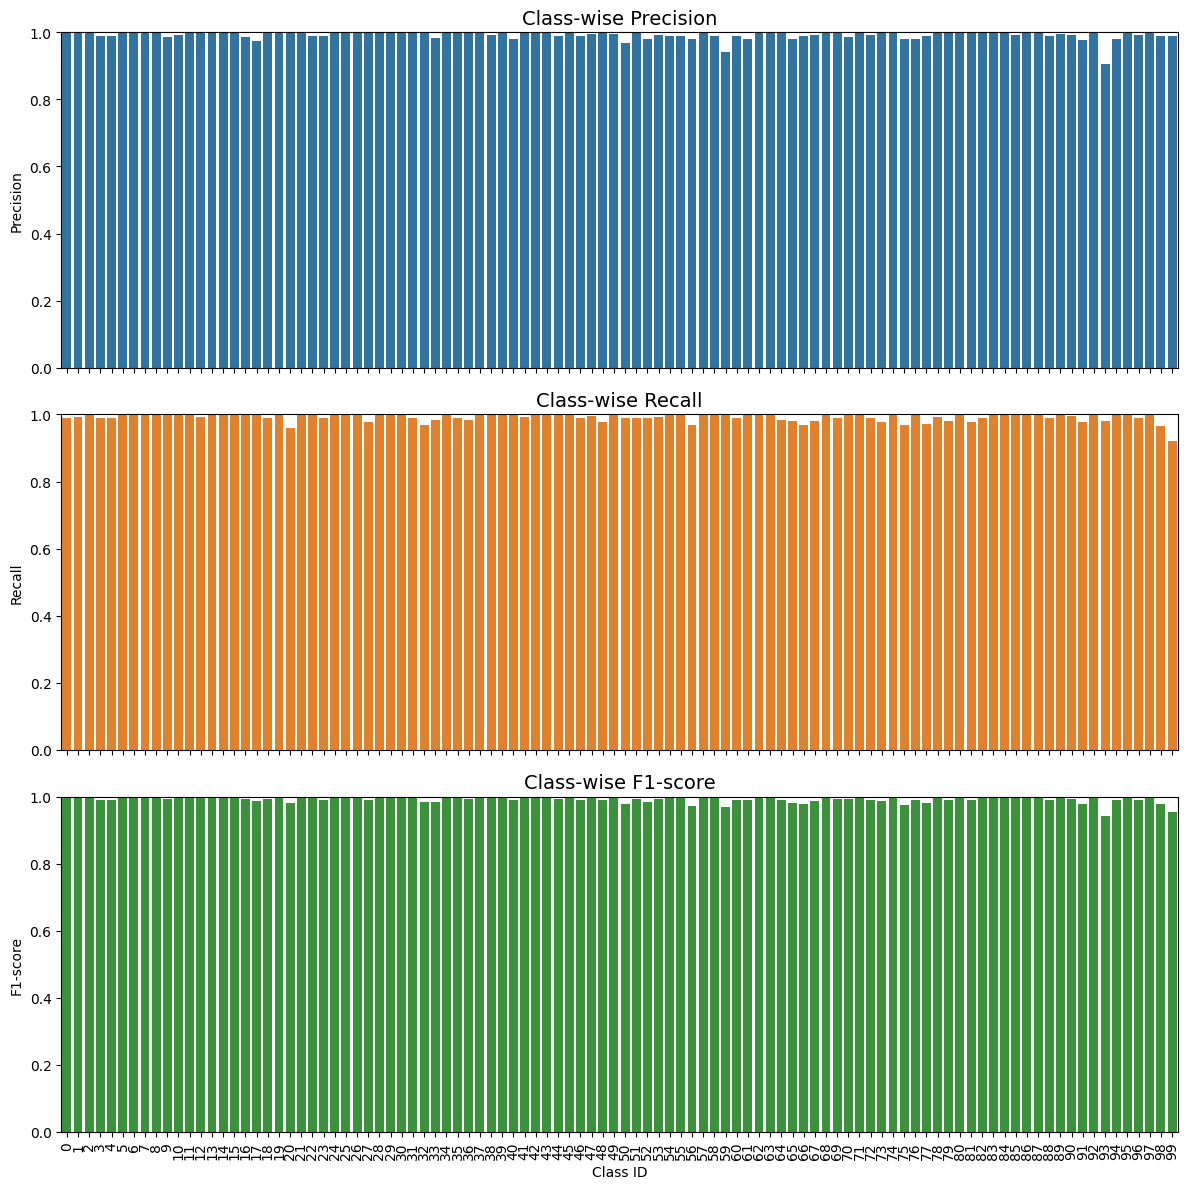

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_CNN)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Convert to DataFrame for visualization
df_report = pd.DataFrame(report).transpose()

# Remove 'accuracy', 'macro avg', 'weighted avg' as they are not per-class metrics
df_report = df_report.iloc[:-3]

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

metrics = ["precision", "recall", "f1-score"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

for i, metric in enumerate(metrics):
    sns.barplot(x=df_report.index, y=df_report[metric], ax=axes[i], color=colors[i])
    axes[i].set_title(f"Class-wise {metric.capitalize()}", fontsize=14)
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_ylim(0, 1)

# Formatting
plt.xticks(rotation=90)
plt.xlabel("Class ID")
plt.tight_layout()
plt.show()

362/362 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


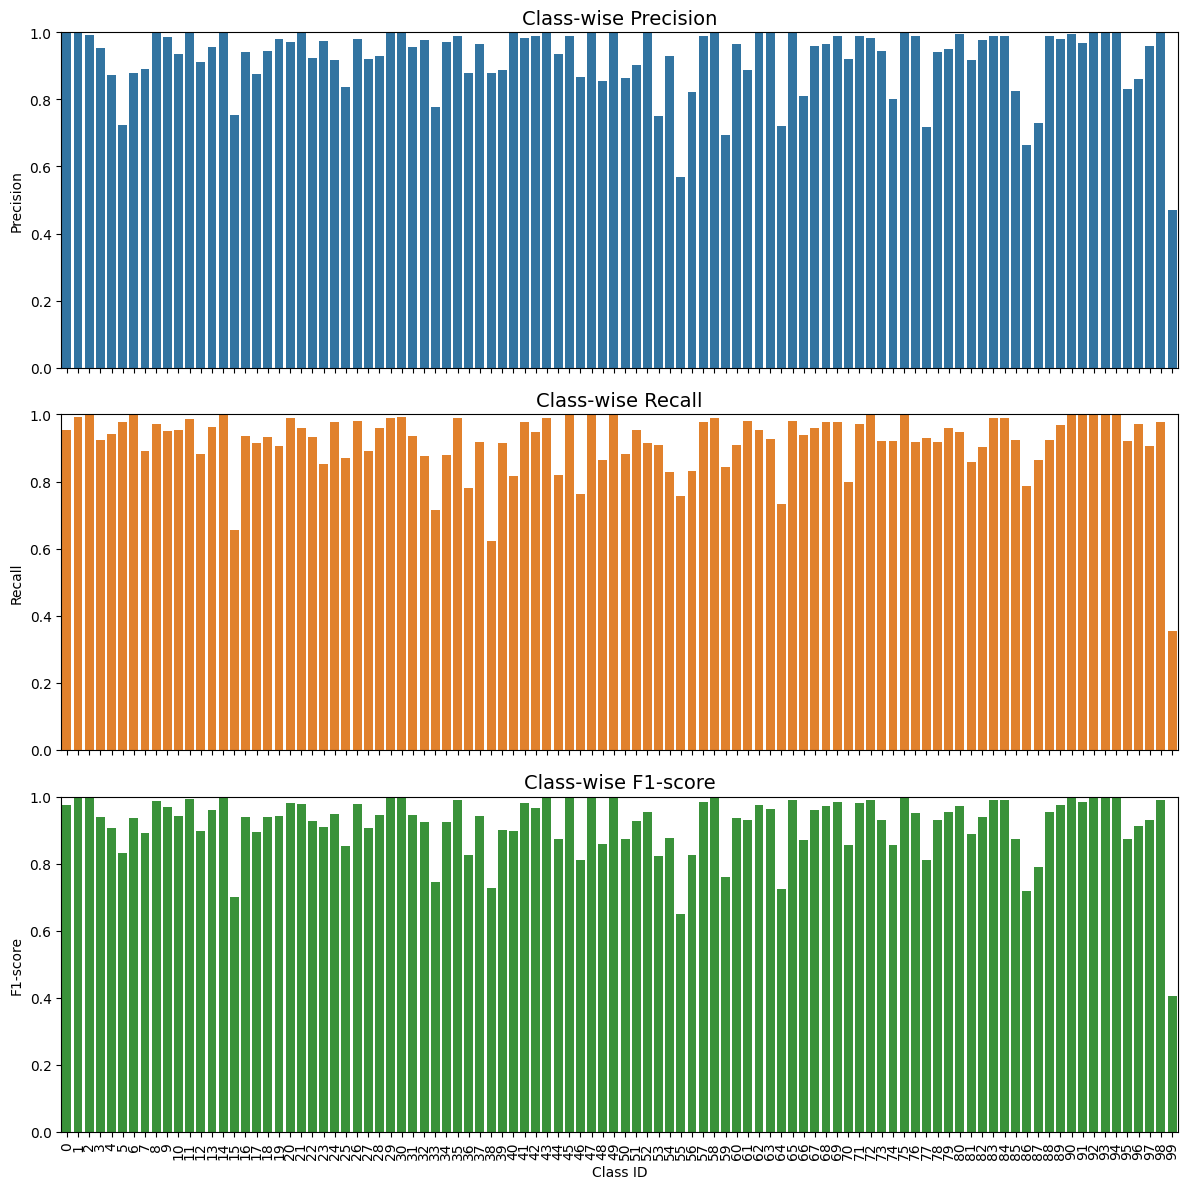

In [ ]:
y_pred = model_ffnn.predict(X_test_embed)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Convert to DataFrame for visualization
df_report = pd.DataFrame(report).transpose()

# Remove 'accuracy', 'macro avg', 'weighted avg' as they are not per-class metrics
df_report = df_report.iloc[:-3]

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

metrics = ["precision", "recall", "f1-score"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, metric in enumerate(metrics):
    sns.barplot(x=df_report.index, y=df_report[metric], ax=axes[i], color=colors[i])
    axes[i].set_title(f"Class-wise {metric.capitalize()}", fontsize=14)
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_ylim(0, 1)

# Formatting
plt.xticks(rotation=90)
plt.xlabel("Class ID")
plt.tight_layout()
plt.show()